### Prediction of property retention in aged FRP composites using XGBoost
Copyright (C) 2025 João Paulo D. de S. Pereira
License: GPL-3.0 (https://www.gnu.org/licenses/gpl-3.0.en.html)

In [1522]:
# Library imports
from category_encoders.target_encoder import TargetEncoder
from contextlib import suppress
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display
from sklearn.metrics import r2_score, PredictionErrorDisplay
from sklearn.model_selection import train_test_split, learning_curve, KFold  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
import time
from datetime import datetime
import seaborn as sns

In [1523]:
# Record and display execution start time
start_time = time.time()
now = datetime.now()
print(now.strftime("%d/%m/%Y %H:%M:%S"))

11/04/2025 17:56:11


In [1524]:
def load_dataset(
        target='Tensile modulus retention',
        file_path=str(os.getcwd()) + '\\Entradas\\degrad_dataset.csv',
        min_target_counts=1,
        cols_to_drop=['Author',
            'Type of resin',
            'Isophtalic polyester resin',
            'Orthophtalic polyester resin',
            'Vinylester resin',
            'Phenolic resin',
            'Epoxy resin',
            'Type of fiber',
            'Glass fiber',
            'Carbon fiber',
            'Manufacturing process',
            'Pultrusion',
            'Hand lay-up',
            'Filament winding',
            'VARTM',
            'Coupon descr.',
            'Aging effect',
            'Steady condition',
            'Cyclic condition',
            'Immersion',
            'Moisture',
            'Presence of salts',
            'pH',
            'Relative humidity',
            'Sustained loading',
            'Exposure time (hours)',
            'Min. exposure temperature (ºC)',
            'Max. exposure temperature (ºC)',
            'Temperature range (ºC)',
            #'Unaged tensile modulus (GPa)',
            'Residual tensile modulus (GPa)'
            ]
        ):
    """Read and process a .CSV file into a filtered pandas DataFrame.

    Args:
        target (string): Column name of the target property.
        min_target_counts (int | float): Minimum count threshold for target
            values. Rows with values appearing fewer times are dropped.
    
    Returns:
        pandas.DataFrame: Filtered dataset with only relevant columns. Rows
            with values appearing fewer times are dropped.
    
    Notes:
        The .CSV file path is hardcoded in this version and not
            user-configurable
        XGBoost is sparsity-aware. No need to drop missing values.
    """

    # Read .CSV as pandas dataframe
    df = pd.read_csv(file_path, delimiter=';')

    # Drop columns that are not important for the analysis
    df = df.drop(columns=cols_to_drop)

    # Remove unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # Filters target property values that appear less than min_target_count times
    value_counts = df[target].value_counts()
    valid_values = value_counts[value_counts > min_target_counts - 1].index
    df = df[df[target].isin(valid_values)]

    return df

In [1525]:
def get_abs_error(y_test, y_pred):  
    """Calculate the maximum signed absolute error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed absolute error (y_pred - y_test), rounded to
                3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.    
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_abs_error(y_test, y_pred)
        -0.4
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i]))
        
    abs_error=0
    if max(abs(i) for i in a) == max(a):
        abs_error = max(a)
    else:
        abs_error = min(a)

    return round(abs_error, 3)

In [1526]:
def get_rel_error(y_test, y_pred):
    """Calculate the maximum signed relative error between predicted and actual
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: Maximum signed relative error ((y_pred - y_test) / y_test),
                rounded to 3 decimals.
        
        Notes:
            Positive values indicate overprediction, negative underprediction.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rel_error(y_test, y_pred)
        -0.167
    """
    
    y_test = y_test.tolist()
    a = []
    for i in range(len(y_test)):
        a.append((y_pred[i] - y_test[i])/y_test[i])
        
    rel_error=0
    if max(abs(i) for i in a) == max(a):
        rel_error = max(a)
    else:
        rel_error = min(a)

    return round(rel_error, 3)

In [1527]:
def get_mae(y_test, y_pred):
    """Calculate the mean absolute error (MAE) between predicted and actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: MAE (Σ(|y_pred - y_test|) / len(y_test)), rounded to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_mae(y_test, y_pred)
        0.233
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + abs(y_pred[i] - y_test[i])
        
    mae = a / len(y_test)

    return round(mae, 3)

In [1528]:
def get_rmse(y_test, y_pred):
    """Calculate the root mean squared error (RMSE) between predicted and
        actual values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: RMSE ((Σ(|y_pred - y_test|)² / len(y_test))^0.5), rounded
                to 3 decimals.
        
        Note:
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_rmse(y_test, y_pred)
        0.265
    """
    
    y_test = y_test.tolist()
    a = 0
    for i in range(len(y_test)):
        a = a + (y_pred[i] - y_test[i]) ** 2
        
    rmse = np.sqrt(a / len(y_test))

    return round(rmse, 3)

In [1529]:
def get_r2(y_test, y_pred):
    """Calculate the coefficient of determination (or R² score) of predicted
        values.
    
    Args:
        y_test (pandas.DataFrame): Actual values.
        y_pred (numpy.ndarray): Predicted values from the model.
    
        Returns:
            float: R² score (1 - RSS/TSS), rounded to 3 decimals.
        
        Note:
            RSS: Residual sum of squares (Σ(y_pred - y_test)²).
            TSS: Total sum of squares (Σ(mean - y_test)²), i.e., variability of
                the actual data.
            An R² score equal to 1 indicates a perfect fit between predicted and
                actual values. An R² equal to 0 means the prediction is no better
                than the mean. A negative R² indicates the prediction is worse
                than the mean.
            Both inputs must have the same length.
        
        Example:
        \\>>> y_test = pd.DataFrame([1.2, 3.4, 5.6])
        \\>>> y_pred = np.array([1.0, 3.5, 5.2])
        \\>>> get_r2(y_test, y_pred)
        0.978
    """
    
    y_test = y_test.tolist()
    mean = sum(y_test) / len(y_test)
    rss = 0  # Residual sum of squares
    tss = 0  # Total sum of squares
    for i in range(len(y_test)):
        rss = rss + (y_pred[i] - y_test[i]) ** 2
        tss = tss + (mean - y_test[i]) ** 2

    r2 = 1 - rss / tss

    return round(r2, 3)

In [ ]:
class Predictor:
    """Train XGBoost model with Bayesian optimization for hyperparameter tuning
        and predict the long-term property retention of aged FRP composites.
    """

    def __init__(
        self,
        model_params: dict = {
            'encoder': TargetEncoder(),
            'clf': {
                'random_state'  :0,
                'booster'       :'gbtree',
                'base_score'    :0.9,
                'eval_metric'   :r2_score
                },
            'bayes_cv': {
                'search_space': {
                    'clf__max_depth'            :Integer(5, 12),
                    'clf__n_estimators'         :Integer(100, 500),
                    'clf__learning_rate'        :Real(0.05, 0.2,
                        prior='log-uniform'),
                    'clf__subsample'            :Real(0.8, 1.0),
                    'clf__colsample_bytree'     :Real(0.8, 1.0),
                    'clf__reg_alpha'            :Real(0.0, 0.5),
                    'clf__reg_lambda'           :Real(0.0, 0.5),
                    'clf__gamma'                :Real(0.0, 0.1),
                    },
                'cv'            :8,
                'n_iter'        :100,
                'scoring'       :'r2',
                'n_jobs'        :6
                }
            },
            target='Tensile modulus retention'
        ):
        """Args:
            model_params (dict): Dictionary containing all model parameters.
                Structure:
                - encoder: Categorical variable encoder.
                - clf: Estimator parameters.
                    - random_state (int): Seed for reproducibility.
                    - booster (str): Booster type.
                    - base_score (float): Initial prediction value.
                    - eval_metric  (Union[str, List[str], Callable, NoneType]):
                        Metric for training result monitoring.
                - bayes_cv: Bayesian optimization parameters (hyperparameter tuning).
                    - search_space: Hyperparameter ranges for optimization.
                    - cv: Number of cross-validation folds.
                    - n_iter: Number of hyperparameter combinations to test.
                    - n_jobs: Number of CPU cores to be used in parallel.
            target (str): Target property.

        Attributes:
            - model_params (dict): Stored model parameters.
            - target (str): Stored target property.
            - dataset (dict): Stored dataset.
            - n_runs (int): Stored number of models to be trained.
            - cv_strategy (KFold): Cross-validation configuration. Shuffling is
                enabled to ensure representative samples in each split.
            - trained_models (list): Will store models and metrics dicts after training.
            - overall_stats (dict): Will store statiscally treated errors and R² score.
            - best_model (XGBRegressor): Will store top-performing model.
        """

        self.model_params   = model_params
        self.target         = target
        self.dataset        = {
            'dataset'           :0,
            'X'                 :0,
            'y'                 :0
        }
        self.n_runs         = 0
        self.cv_strategy    = KFold(n_splits=5, shuffle=True, random_state=0)
        self.trained_models = []
        self.overall_stats  = {
            'abs_error_mean'    :0,
            'abs_error_std'     :0,
            'rel_error_mean'    :0,
            'rel_error_std'     :0,
            'mae_mean'          :0,
            'mae_std'           :0,
            'rmse_mean'         :0,
            'rmse_std'          :0,
            'r2_mean'           :0,
            'r2_std'            :0
        }
        self.best_model     = None
        
    def create_model(self, log_transf=[]):
        """Create model and configure the training pipeline with Bayesian
            optimization.

        Returns:
            skopt.BayesSearchCV: Configured Bayesian optimization search object ready
                for fitting.
        """
        
        # Load dataset
        df = load_dataset()

        # Log-transform features with outlier values
        for i in range(len(log_transf)):
            df[log_transf[i]] = np.log10(df[log_transf[i]])
        
        # Separate independent variables from target
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Store dataset and splits
        self.dataset['dataset'] = df
        self.dataset['X'] = X
        self.dataset['y'] = y

        # Configure training pipeline and hyperparameter tuning
        estimators = [
            ('encoder', self.model_params['encoder']),
            ('clf', XGBRegressor(
                random_state            =self.model_params['clf']['random_state'],
                booster                 =self.model_params['clf']['booster'],
                base_score              =self.model_params['clf']['base_score'],
                eval_metric             =self.model_params['clf']['eval_metric'],
                objective               ='reg:squarederror'
                )
            )
        ]
                
        opt = BayesSearchCV(
            Pipeline(steps=estimators),
            self.model_params['bayes_cv']['search_space'],
            cv                  = self.cv_strategy,
            n_iter              = self.model_params['bayes_cv']['n_iter'],
            scoring             = self.model_params['bayes_cv']['scoring'],
            error_score         = 'raise',
            random_state        = 0,
            return_train_score  = True,
            n_jobs              = self.model_params['bayes_cv']['n_jobs'],
            n_points            = 1,
            verbose             = False
            )
        
        return opt

    def train(self, n_runs=10, q=5, test_size=0.2, best_metric='r2', log_transf=[]):
        """Train n_runs models with different data splits, calculate and store
            their metrics.

        Args:
            dataset (pandas.DataFrame): Dataset.
            n_runs (int): Number of times the dataset will be split for new
                trainings. Default is 10.
            q (int): Number of quantiles in data stratification. Default is 5.
            test_size (int): Fraction of the dataset used for validation.
                Default is 0.2.
            best_metric (str): Metric defining the best model. Default is R².
        """

        # Create model
        model = self.create_model(log_transf=log_transf)

        # Load dataset
        df = self.dataset['dataset']
        X = df.drop(columns=self.target)
        y = df[self.target]
        
        # Restart attributes
        self.n_runs = n_runs
        self.trained_models = []

        # Bin the continuous target into categories for stratification
        bins = pd.qcut(y, q=q, duplicates='drop')

        loop_start = time.time()
        for i in range(n_runs):

            # Split data in training and test groups
            X_train, X_test, y_train, y_test = train_test_split(X, y,
                test_size=test_size, stratify=bins#, random_state=i
                )
        
            # Train model
            print('Starting fit #', i+1, sep='')
            fit_start = time.time()
            print(datetime.now().strftime("%d/%m/%Y %H:%M:%S\n"))
            model.fit(X_train, y_train)
            fit_finish = time.time()
            print('Fit #', i+1, ' is finished! (%s s)\n'
                % round((fit_finish - fit_start), 1), sep='')
            if i == n_runs - 1:
                print('Total training duration: %s s\n'
                    % round((fit_finish - loop_start), 1), sep='')
            y_pred = model.predict(X_test)
            model_info = {
                'id': i,
                'model': model.best_estimator_,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_pred': y_pred,
                'y_test': y_test,
                'abs_error': get_abs_error(y_test, y_pred),
                'rel_error': get_rel_error(y_test, y_pred),
                'mae': get_mae(y_test, y_pred),
                'rmse': get_rmse(y_test, y_pred),
                'r2': get_r2(y_test, y_pred),
                'best_cv_score': model.best_score_,
                'best_params': model.best_params_,
                'importance_plot': model.best_estimator_.steps[1][1],
                'importance_score': model.best_estimator_.steps[1][1].
                    get_booster().get_score(importance_type='weight')
                }
            self.trained_models.append(model_info)
        
        # Extract metrics, calculate and store statistics
        abs_error = [self.trained_models[i]['abs_error']
            for i in range(len(self.trained_models))]
        abs_error_mean = np.mean(abs_error)
        abs_error_std = np.std(abs_error)
        self.overall_stats['abs_error_mean'] = abs_error_mean
        self.overall_stats['abs_error_std'] = abs_error_std
        print(f"Abs. error: {abs_error_mean:.3f} ± {abs_error_std:.3f}")

        rel_error = [self.trained_models[i]['rel_error']
            for i in range(len(self.trained_models))]
        rel_error_mean = np.mean(rel_error)
        rel_error_std = np.std(rel_error)
        self.overall_stats['rel_error_mean'] = rel_error_mean
        self.overall_stats['rel_error_std'] = rel_error_std
        print(f"Rel. error: {rel_error_mean:.3f} ± {rel_error_std:.3f}")

        mae = [self.trained_models[i]['mae']
            for i in range(len(self.trained_models))]
        mae_mean = np.mean(mae)
        mae_std = np.std(mae)
        self.overall_stats['mae_mean'] = mae_mean
        self.overall_stats['mae_std'] = mae_std
        print(f"MAE: {mae_mean:.3f} ± {mae_std:.3f}")

        rmse = [self.trained_models[i]['rmse']
            for i in range(len(self.trained_models))]
        rmse_mean = np.mean(rmse)
        rmse_std = np.std(rmse)
        self.overall_stats['rmse_mean'] = rmse_mean
        self.overall_stats['rmse_std'] = rmse_std
        print(f"RMSE: {rmse_mean:.3f} ± {rmse_std:.3f}")

        r2 = [self.trained_models[i]['r2']
            for i in range(len(self.trained_models))]
        r2_mean = np.mean(r2)
        r2_std = np.std(r2)
        self.overall_stats['r2_mean'] = r2_mean
        self.overall_stats['r2_std'] = r2_std
        print(f"R²: {r2_mean:.2f} ± {r2_std:.2f}\n")
    
        # Store the best model
        best_model = max(self.trained_models, key=lambda x: x['r2'])
        self.best_model = best_model
    
    def plot_learning_curves(self, q=5, test_size=0.2, metrics=[0,0,1]):
        """...

        Args:
            ...
            metrics (list): List with metrics to be plotted: MAE, RMSE, and R²,
                respectively. 1 is plot, 0 is not plot. Default is to plot only R²
        """
        
        # Separate independent variables from target
        X = self.dataset['X']
        y = self.dataset['y']

        # Bin the continuous target into categories for stratification
        bins = pd.qcut(y, q=q, duplicates='drop')

        # Split into train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=bins, test_size=test_size)

        # Define marker styles for different models
        markers = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'X', 'd']  # Add more if needed
        fill = ['full', 'none']  # Alternate filled/unfilled

        if metrics[0] == 1:
            plt.figure(figsize=(10, 6))
            
            train_score_total = []
            test_score_total = []

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='neg_mean_absolute_error', return_times=True
                )

                # Converting MAE ro positive
                train_scores = -train_scores
                test_scores = -test_scores

                print(f'\nModel {i+1}')

                d = []
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    print(f"CV {j+1}: {a} samples, train MAE = {b.mean():.3f}, valid MAE = {c.mean():.3f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
                
            print(f"Train MAE: {np.mean(train_score_total):.3f} ± {np.std(train_score_total):.3f}")
            print(f"Valid MAE: {np.mean(test_score_total):.3f} ± {np.std(test_score_total):.3f}")

            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("MAE")
            plt.ylim(0, 0.2)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='lower right')

            plt.tight_layout()
            plt.show()


        if metrics[1] == 1:
            plt.figure(figsize=(10, 6))

            train_score_total = []
            test_score_total = []

            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='neg_root_mean_squared_error', return_times=True
                )

                # Converting MAE ro positive
                train_scores = -train_scores
                test_scores = -test_scores

                print(f'\nModel {i+1}')

                d = []
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    print(f"CV {j+1}: {a} samples, train RMSE = {b.mean():.3f}, valid RMSE = {c.mean():.3f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
            
            print(f"Train RMSE: {np.mean(train_score_total):.3f} ± {np.std(train_score_total):.3f}")
            print(f"Valid RMSE: {np.mean(test_score_total):.3f} ± {np.std(test_score_total):.3f}")

            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("RMSE")
            plt.ylim(0, 0.2)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='lower right')

            plt.tight_layout()
            plt.show()


        if metrics[2] == 1:
            plt.figure(figsize=(10, 6))

            train_score_total = []
            test_score_total = []
        
            for i in range(len(self.trained_models)):
                train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(  
                    self.trained_models[i]['model'], X, y, train_sizes=np.linspace(0.1, 1.0, 8),
                    cv=self.cv_strategy, scoring='r2', return_times=True
                )

                print(f'\nModel {i+1}')

                d =[]
                for j, (a, b, c) in enumerate(zip(train_sizes, train_scores, test_scores)):
                    print(f"CV {j+1}: {a} samples, train R² = {b.mean():.2f}, valid R² = {c.mean():.2f} ({sum(fit_times[j]):.2f} s)")
                    d.append(sum(fit_times[j]))
                    if j == len(train_sizes) - 1:
                        train_score_total.append(b)
                        test_score_total.append(c)
                print(f"{sum(d):.0f} s in total")

                # Calculate training and validation means and stds
                train_mean = np.mean(train_scores, axis=1)
                train_std = np.std(train_scores, axis=1)
                test_mean = np.mean(test_scores, axis=1)
                test_std = np.std(test_scores, axis=1)

                # Define marker and fill styles
                marker = markers[i // 2 % len(markers)]  # Change marker every 2 models
                fillstyle = fill[i % 2]  # Alternate fill for each model

                # Plot training curve
                plt.plot(
                    train_sizes,
                    train_mean,
                    marker=marker,
                    fillstyle=fillstyle,
                    color='blue',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Train' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    train_mean - train_std,
                    train_mean + train_std,
                    alpha=0.05,
                    color='blue'
                    )

                # Plot validation curve
                plt.plot(
                    train_sizes,
                    test_mean,
                    marker=marker,
                    color='red',
                    linestyle='-',
                    alpha=0.4,
                    label=f'Validation' if i == 0 else ''
                    )
                plt.fill_between(
                    train_sizes,
                    test_mean - test_std,
                    test_mean + test_std,
                    alpha=0.05,
                    color='red'
                    )
                    
            print(f"Train R²: {np.mean(train_score_total):.2f} ± {np.std(train_score_total):.2f}")
            print(f"Valid R²: {np.mean(test_score_total):.2f} ± {np.std(test_score_total):.2f}")
            
            # Plot formatting
            plt.xlabel("Training set size")
            plt.ylabel("R² score")
            plt.ylim(0, 1)  # Adjust based on your scores
            plt.title('Learning curves across models')
            plt.grid(True)

            # Create custom legend
            legend_elements = []
            legend_elements.extend([
                Line2D([0], [0], color='blue', lw=2, label='Training'),
                Line2D([0], [0], color='red', lw=2, label='Validation')
            ])

            for i in range(len(self.trained_models)):
                marker_idx = i // 2 % len(markers)
                fill_idx = i % 2
                legend_elements.append(Line2D(
                    [0], [0],
                    marker=markers[marker_idx],
                    fillstyle=fill[fill_idx],
                    color='gray',
                    label=f'Model {i+1}',
                    linestyle='None',
                    markersize=10
                ))

            plt.legend(handles=legend_elements, ncol=3, loc='lower right')

            plt.tight_layout()
            plt.show()

    def plot_feature_distribution(self, main_feature='Exposure time (days)'):
        """...
        """
        
        df = self.dataset['dataset']
        
        print('\nTarget boxplot distribution')
        sns.boxplot(x=self.dataset['y'])  # Check target
        plt.show()

        print('\nOverall feature distribution')
        sns.pairplot(df)  # Check feature distributions
        # sns.pairplot(df, diag_kind='kde')  # Unncomment for smoothed curves
        plt.show()

        #  Outlier identification for most important feature
        print('\nMost important feature vs. target')
        sns.scatterplot(x=main_feature, y=self.target, data=df)
        plt.show()

        # Check individual feature distribution
        print('\nMost important feature distribution')
        display(self.dataset['X'][main_feature].value_counts())

    def plot_pred_error(self):
        for i in range(len(self.trained_models)):
            print(f'\nModel {i+1}')
            display = PredictionErrorDisplay.from_predictions(
                self.trained_models[i]['y_test'],
                self.trained_models[i]['y_pred'],
                kind="actual_vs_predicted")
            display.plot()
            plt.show()
    
    def plot_importance(self):
        # Importance types: ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
        for i in range(len(self.trained_models)):
            print(f'\nModel {i+1}')
            self.trained_models[i]['importance_score']
            with plt.style.context("ggplot"):
                fig = plt.figure(figsize=(6,6))
                ax = fig.add_subplot(111)
                xgb.plotting.plot_importance(self.trained_models[i]['importance_plot'], ax=ax)
            plt.show()

    def plot_tree(self, n_model=0, n_tree=0):
        with plt.style.context("ggplot"):
            fig = plt.figure(figsize=(25,10))
            ax = fig.add_subplot(111)
            xgb.plotting.plot_tree(self.trained_models[n_model]['importance_plot'], ax=ax, num_trees=n_tree)
    
    def bootstrap(self):
        """Calc...
        """

        metrics = {
            'mae': [],
            'rmse': [],
            'r2': []
        }

        model = self.best_model

    def predict(self, model):
        pass

In [1531]:
import pandas as pd

X = predictor.dataset['X'].drop(columns='Type of fiber')
y = predictor.dataset['y'].drop(columns='Type of fiber')

# Calculate correlations
corr = pd.DataFrame(X).corrwith(pd.Series(y))
print(corr.sort_values(ascending=False))

Coupon thick. (mm)                0.122430
Unaged tensile modulus (GPa)     -0.036156
V_f                              -0.074011
Avg. exposure temperature (ºC)   -0.125702
Exposure time (days)             -0.129306
Salt conc. (g/L)                 -0.156237
dtype: float64


In [1532]:
predictor = Predictor(target='Tensile modulus retention')
predictor.train(n_runs=4, log_transf=['Exposure time (days)'])

Starting fit #1
11/04/2025 17:56:12

Fit #1 is finished! (435.7 s)

Starting fit #2
11/04/2025 18:03:28

Fit #2 is finished! (357.2 s)

Starting fit #3
11/04/2025 18:09:25

Fit #3 is finished! (345.4 s)

Starting fit #4
11/04/2025 18:15:10

Fit #4 is finished! (328.0 s)

Total training duration: 1466.4 s

Abs. error: 0.030 ± 0.241
Rel. error: 0.264 ± 0.026
MAE: 0.048 ± 0.002
RMSE: 0.068 ± 0.002
R²: 0.54 ± 0.11




Model 1
CV 1: 31 samples, train MAE = 0.035, valid MAE = 0.178 (0.65 s)
CV 2: 72 samples, train MAE = 0.025, valid MAE = 0.118 (0.71 s)
CV 3: 112 samples, train MAE = 0.025, valid MAE = 0.081 (0.80 s)
CV 4: 153 samples, train MAE = 0.025, valid MAE = 0.069 (0.93 s)
CV 5: 194 samples, train MAE = 0.024, valid MAE = 0.068 (0.97 s)
CV 6: 234 samples, train MAE = 0.026, valid MAE = 0.054 (1.12 s)
CV 7: 275 samples, train MAE = 0.027, valid MAE = 0.050 (1.21 s)
CV 8: 316 samples, train MAE = 0.026, valid MAE = 0.046 (1.40 s)
8 s in total

Model 2
CV 1: 31 samples, train MAE = 0.034, valid MAE = 0.176 (0.66 s)
CV 2: 72 samples, train MAE = 0.025, valid MAE = 0.118 (0.80 s)
CV 3: 112 samples, train MAE = 0.024, valid MAE = 0.081 (0.89 s)
CV 4: 153 samples, train MAE = 0.025, valid MAE = 0.068 (1.06 s)
CV 5: 194 samples, train MAE = 0.024, valid MAE = 0.067 (1.14 s)
CV 6: 234 samples, train MAE = 0.026, valid MAE = 0.053 (1.41 s)
CV 7: 275 samples, train MAE = 0.027, valid MAE = 0.050 (1.43 s

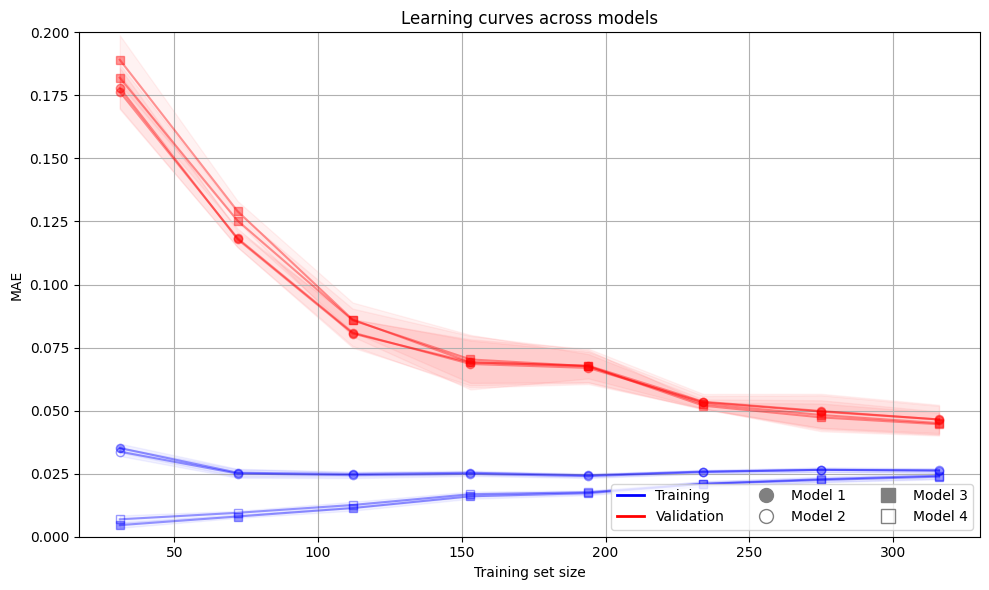


Model 1
CV 1: 31 samples, train RMSE = 0.049, valid RMSE = 0.214 (0.95 s)
CV 2: 72 samples, train RMSE = 0.037, valid RMSE = 0.154 (0.75 s)
CV 3: 112 samples, train RMSE = 0.034, valid RMSE = 0.116 (0.92 s)
CV 4: 153 samples, train RMSE = 0.035, valid RMSE = 0.101 (0.98 s)
CV 5: 194 samples, train RMSE = 0.034, valid RMSE = 0.104 (1.09 s)
CV 6: 234 samples, train RMSE = 0.035, valid RMSE = 0.074 (1.15 s)
CV 7: 275 samples, train RMSE = 0.036, valid RMSE = 0.068 (1.24 s)
CV 8: 316 samples, train RMSE = 0.035, valid RMSE = 0.063 (1.46 s)
9 s in total

Model 2
CV 1: 31 samples, train RMSE = 0.048, valid RMSE = 0.212 (0.83 s)
CV 2: 72 samples, train RMSE = 0.036, valid RMSE = 0.155 (1.00 s)
CV 3: 112 samples, train RMSE = 0.033, valid RMSE = 0.117 (1.12 s)
CV 4: 153 samples, train RMSE = 0.035, valid RMSE = 0.102 (1.21 s)
CV 5: 194 samples, train RMSE = 0.033, valid RMSE = 0.103 (1.13 s)
CV 6: 234 samples, train RMSE = 0.035, valid RMSE = 0.073 (1.30 s)
CV 7: 275 samples, train RMSE = 0.0

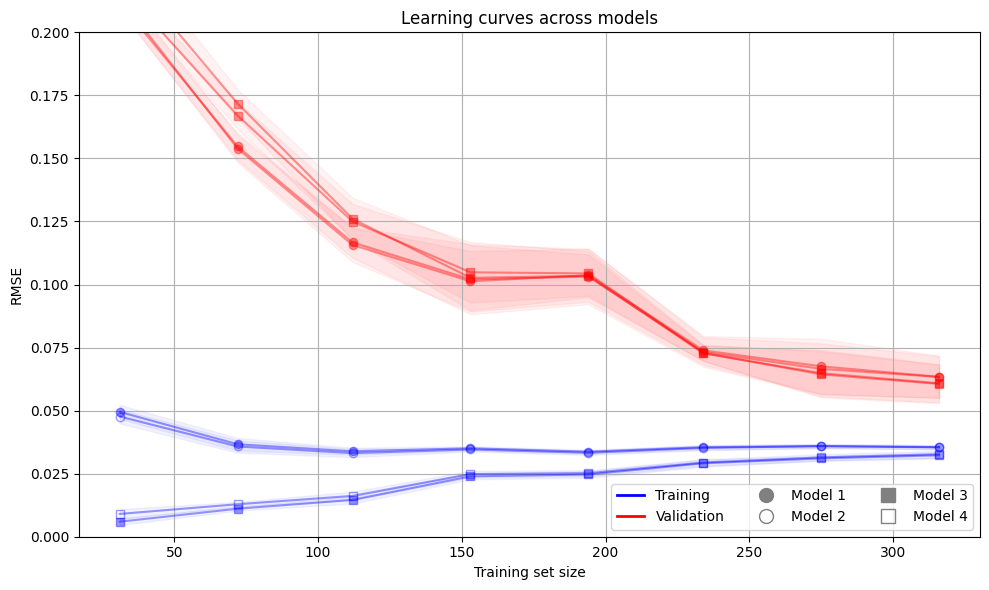


Model 1
CV 1: 31 samples, train R² = 0.83, valid R² = -3.08 (0.68 s)
CV 2: 72 samples, train R² = 0.90, valid R² = -1.08 (0.70 s)
CV 3: 112 samples, train R² = 0.91, valid R² = -0.17 (0.79 s)
CV 4: 153 samples, train R² = 0.89, valid R² = 0.11 (0.90 s)
CV 5: 194 samples, train R² = 0.88, valid R² = 0.07 (0.94 s)
CV 6: 234 samples, train R² = 0.90, valid R² = 0.53 (1.08 s)
CV 7: 275 samples, train R² = 0.89, valid R² = 0.61 (1.15 s)
CV 8: 316 samples, train R² = 0.89, valid R² = 0.66 (1.29 s)
8 s in total

Model 2
CV 1: 31 samples, train R² = 0.84, valid R² = -3.00 (0.67 s)
CV 2: 72 samples, train R² = 0.91, valid R² = -1.10 (0.80 s)
CV 3: 112 samples, train R² = 0.91, valid R² = -0.19 (0.86 s)
CV 4: 153 samples, train R² = 0.89, valid R² = 0.10 (1.00 s)
CV 5: 194 samples, train R² = 0.88, valid R² = 0.08 (1.15 s)
CV 6: 234 samples, train R² = 0.90, valid R² = 0.53 (1.20 s)
CV 7: 275 samples, train R² = 0.89, valid R² = 0.62 (1.52 s)
CV 8: 316 samples, train R² = 0.89, valid R² = 0.66 

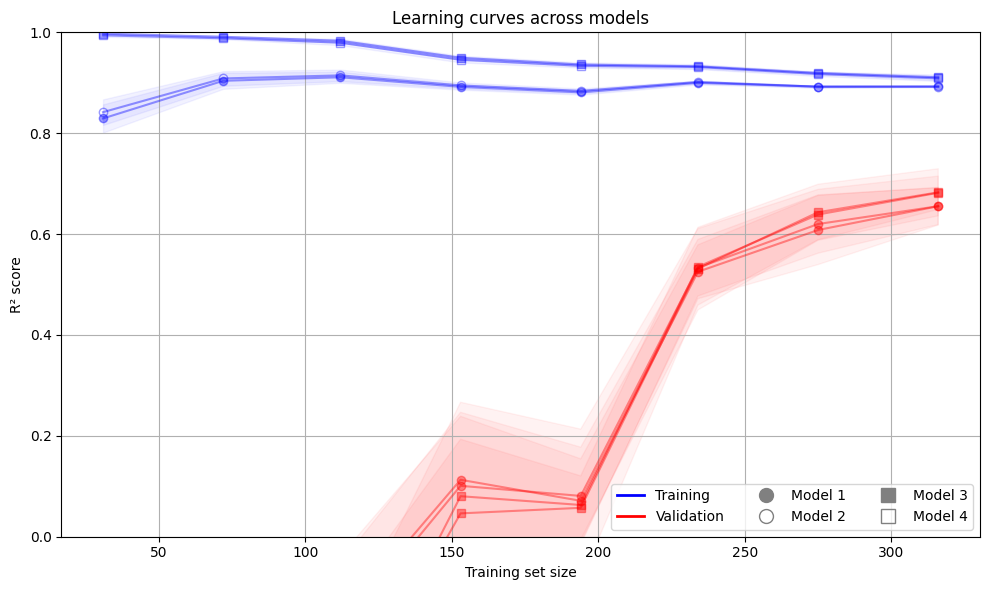

In [1533]:
predictor.plot_learning_curves(metrics=[1,1,1])


Target boxplot distribution


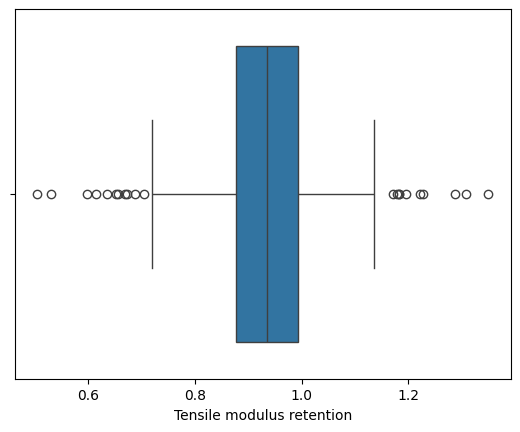


Overall feature distribution


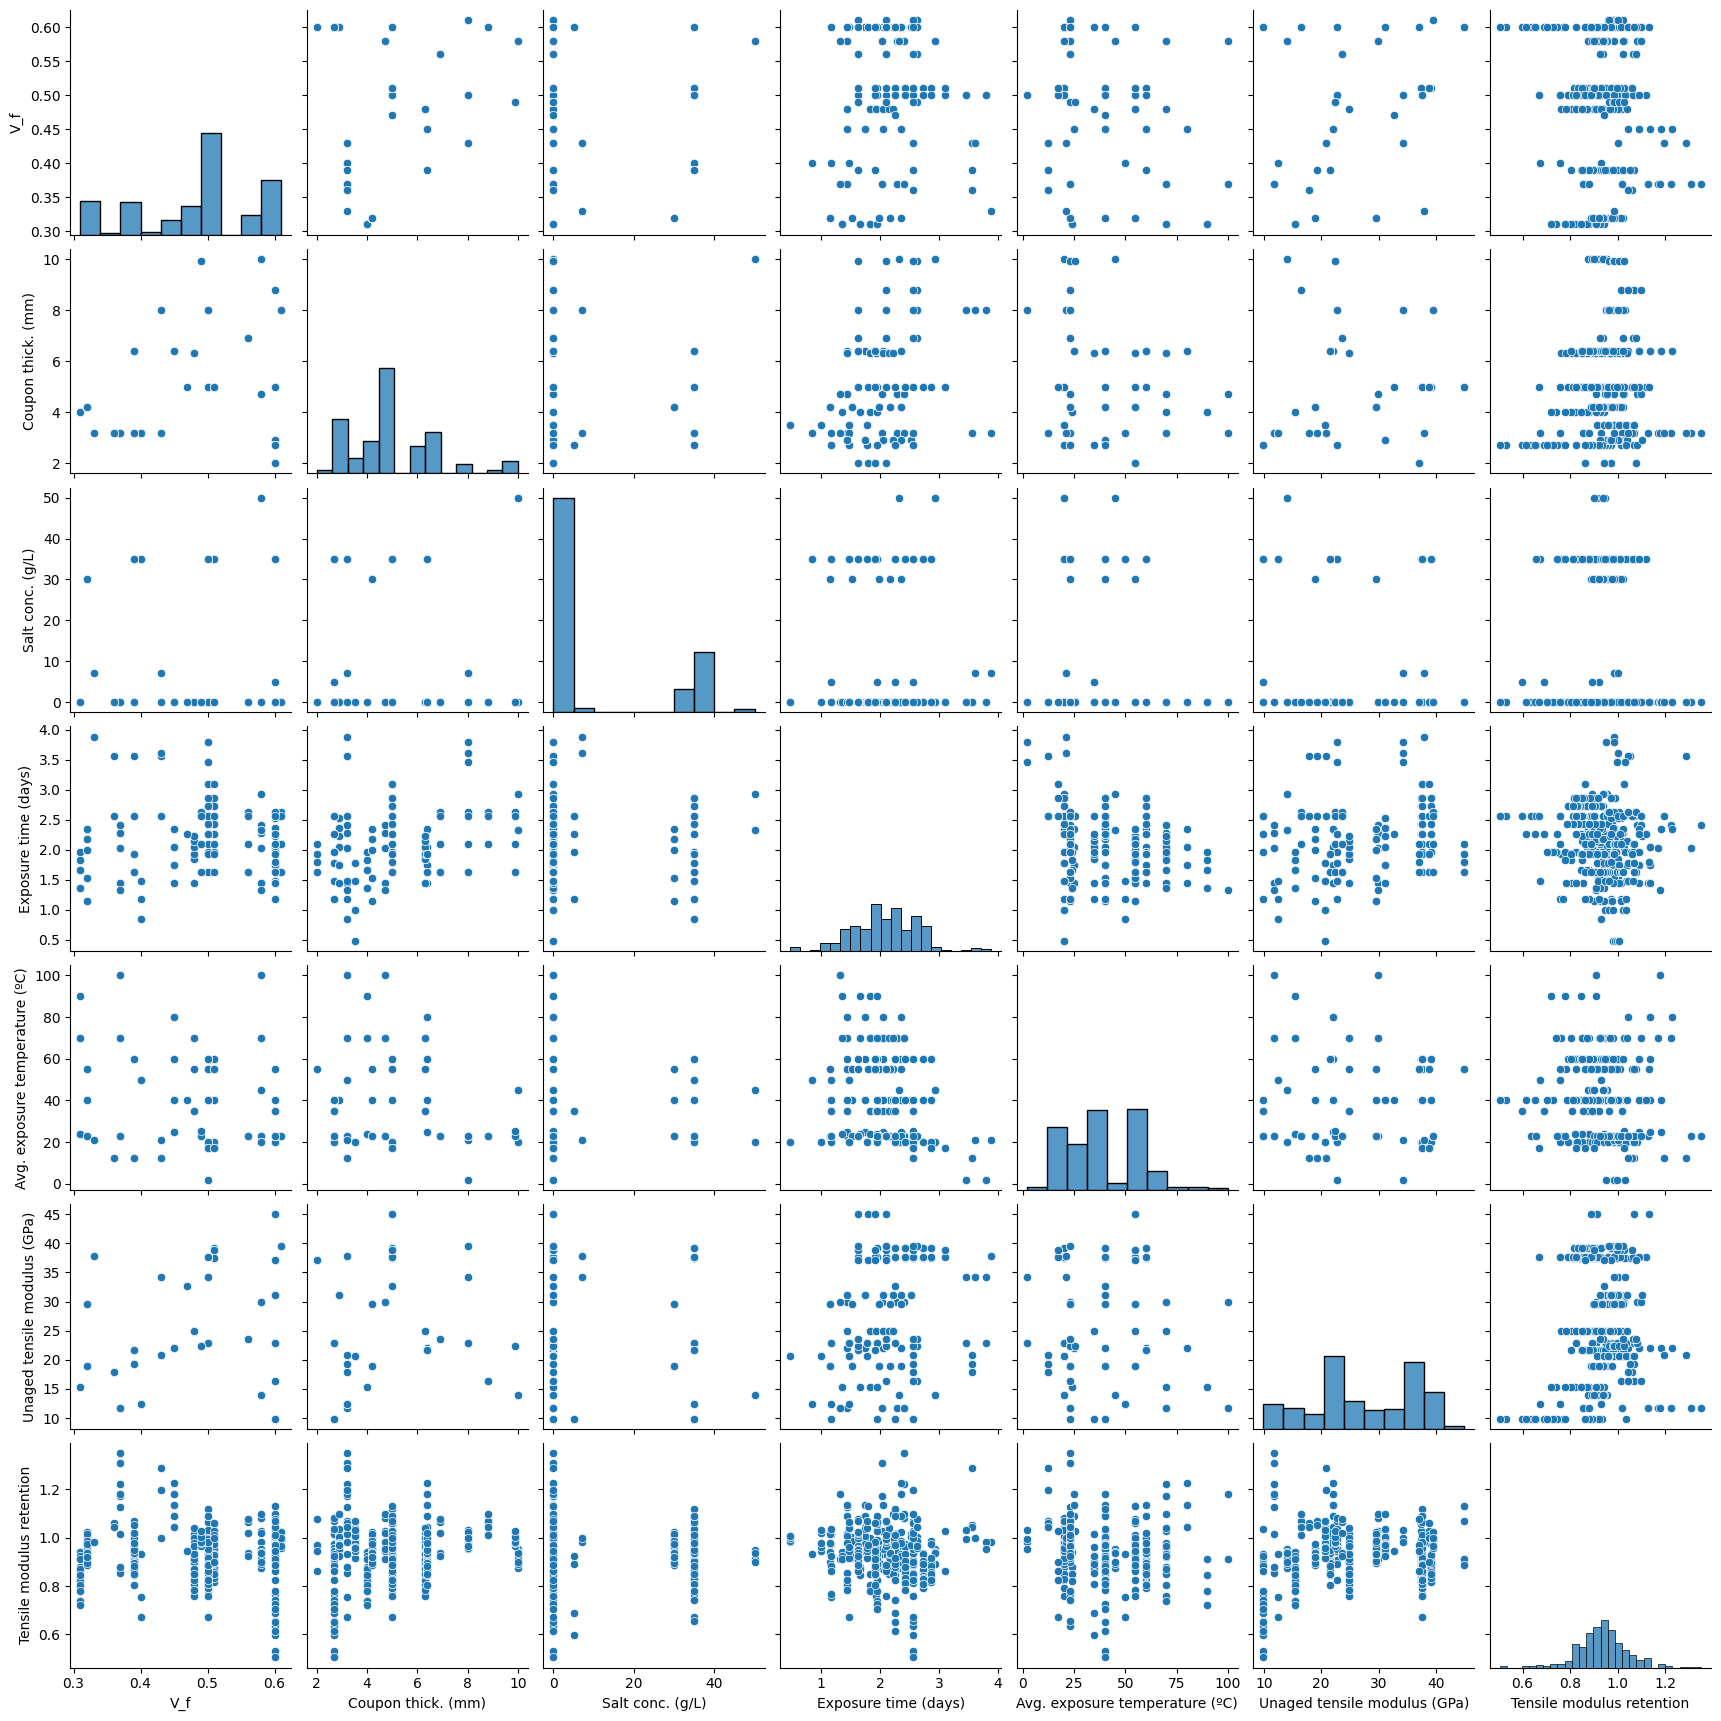


Most important feature vs. target


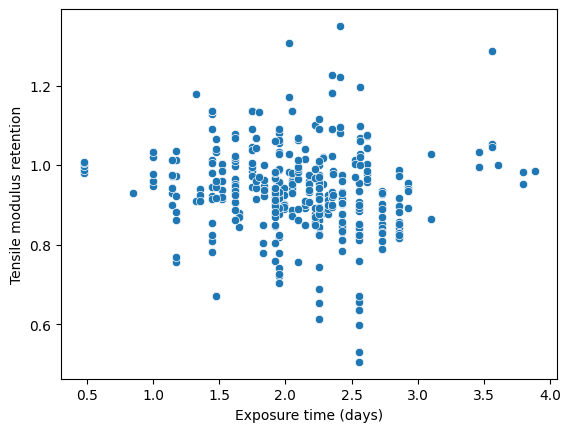


Most important feature distribution


Exposure time (days)
1.954243    30
2.255273    28
2.556303    26
1.623249    24
2.431364    20
1.919078    19
2.732394    19
1.447158    17
2.857332    14
2.049218    13
2.096910    12
2.350248    10
1.748188    10
2.620136     9
2.225309     9
1.477121     8
1.176091     8
2.562293     7
1.778151     7
1.835691     6
1.986772     6
2.146128     6
1.924279     6
2.176091     6
1.146128     6
1.518514     6
1.000000     5
0.477121     5
2.322219     5
2.924279     5
2.283301     4
2.029384     4
2.414973     4
1.829304     3
2.526339     3
1.653213     3
1.352183     3
3.562293     3
2.357935     3
3.792742     2
3.100371     2
1.799341     2
3.465383     2
1.322219     2
3.603686     1
3.884512     1
0.845098     1
Name: count, dtype: int64

In [1534]:
predictor.plot_feature_distribution(main_feature='Exposure time (days)')


Model 1


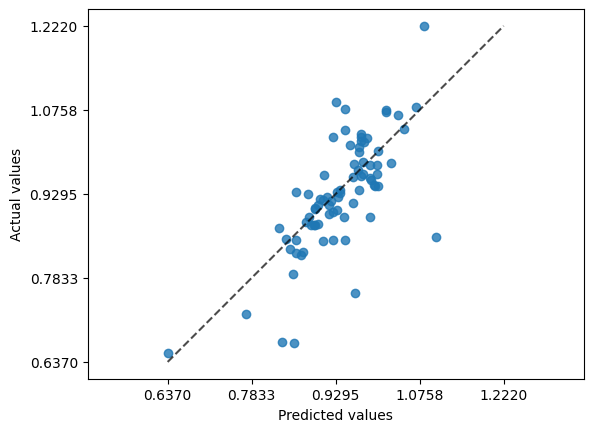

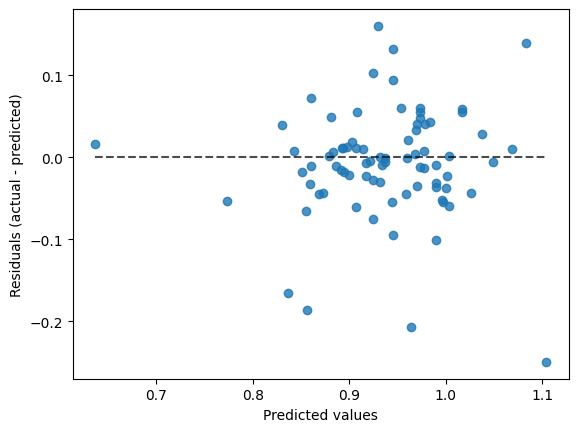


Model 2


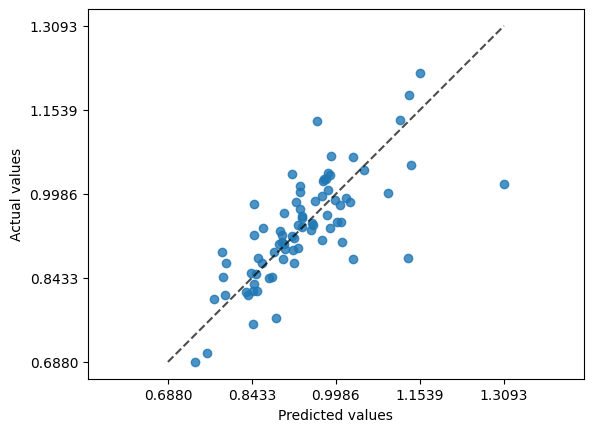

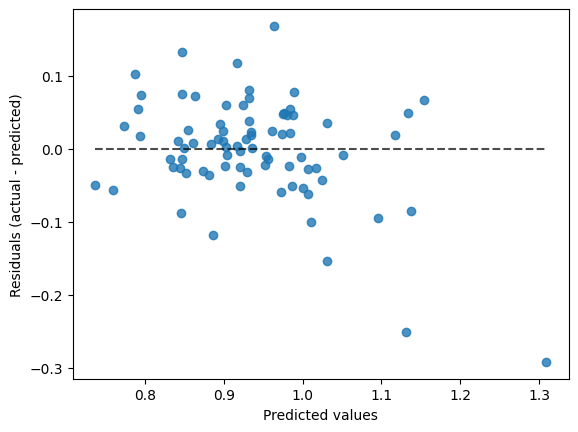


Model 3


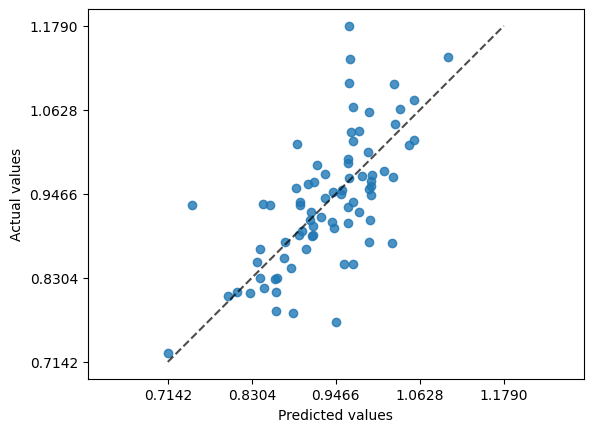

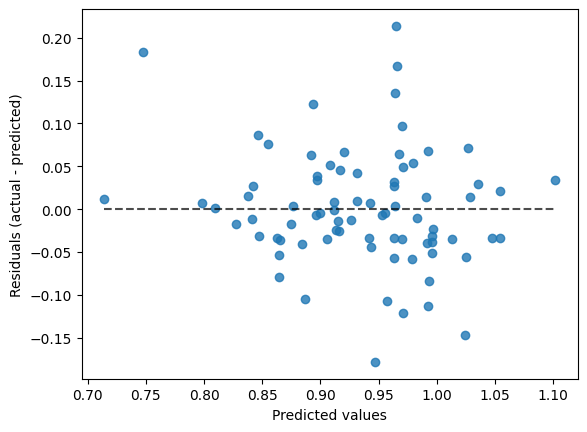


Model 4


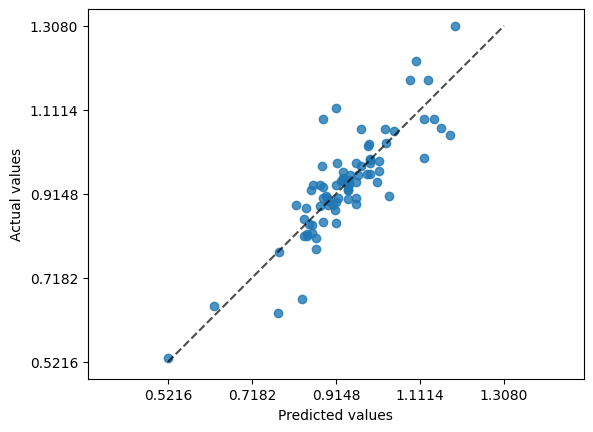

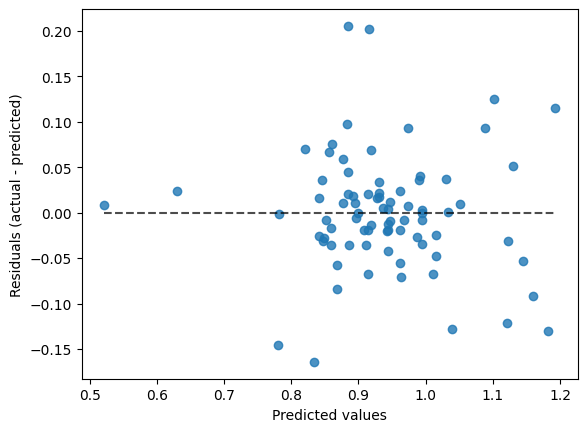

In [1535]:
predictor.plot_pred_error()


Model 1


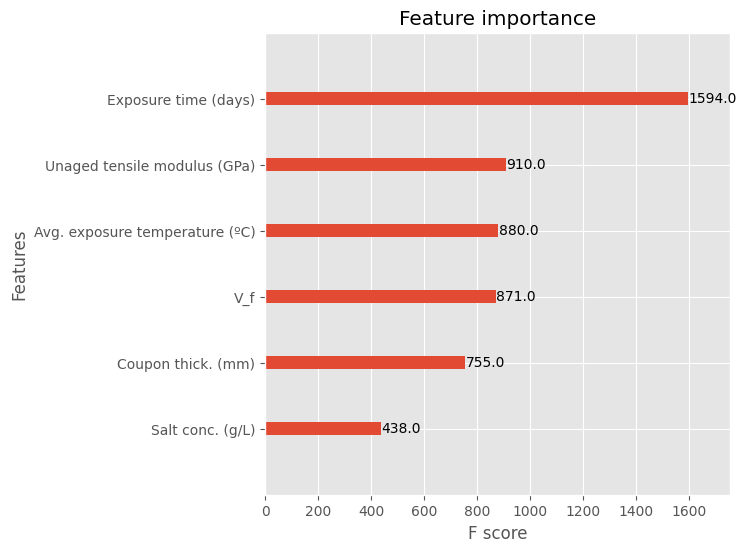


Model 2


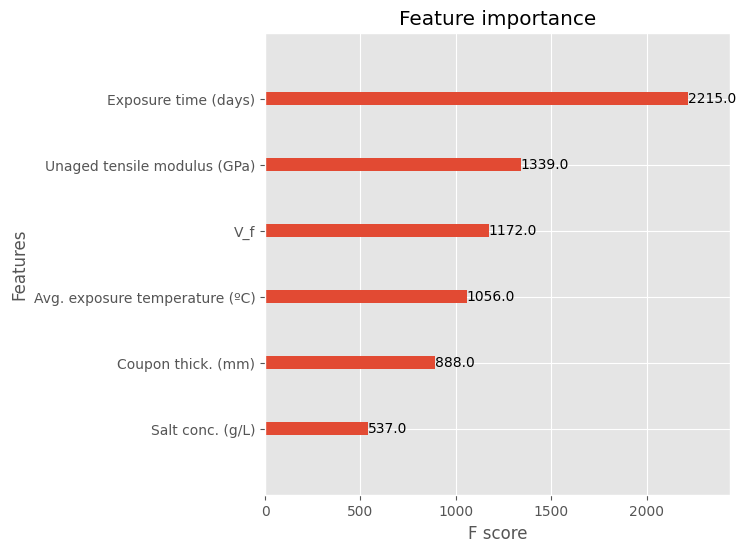


Model 3


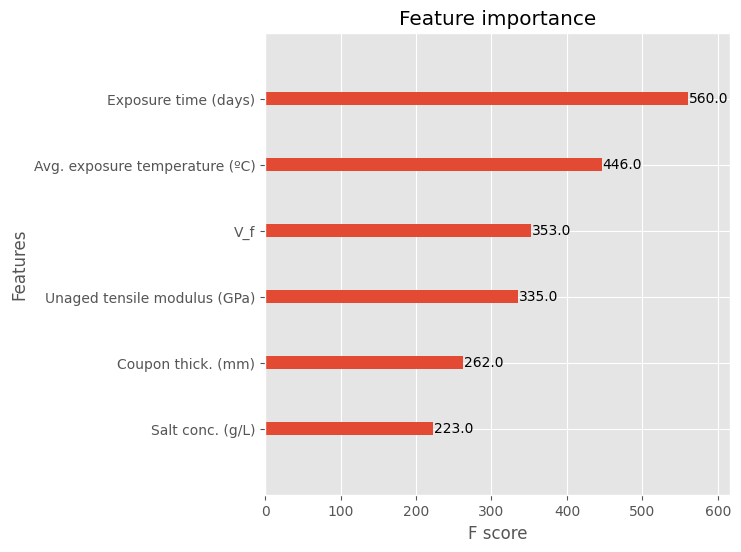


Model 4


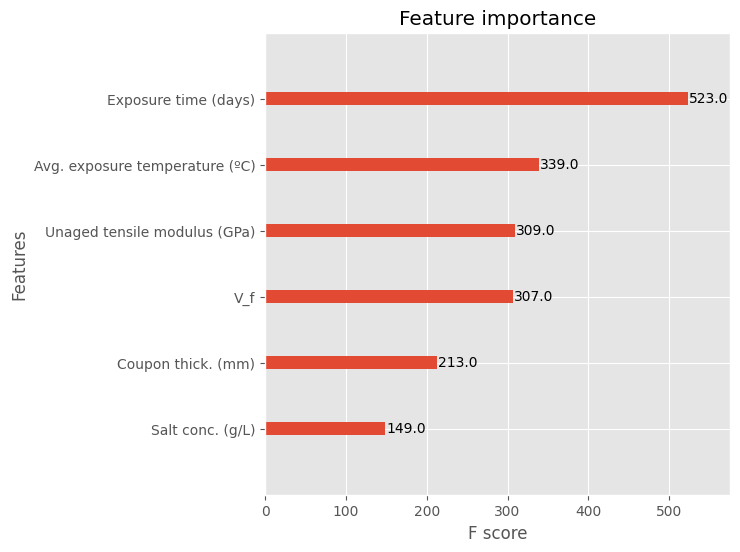

In [1536]:
predictor.plot_importance()

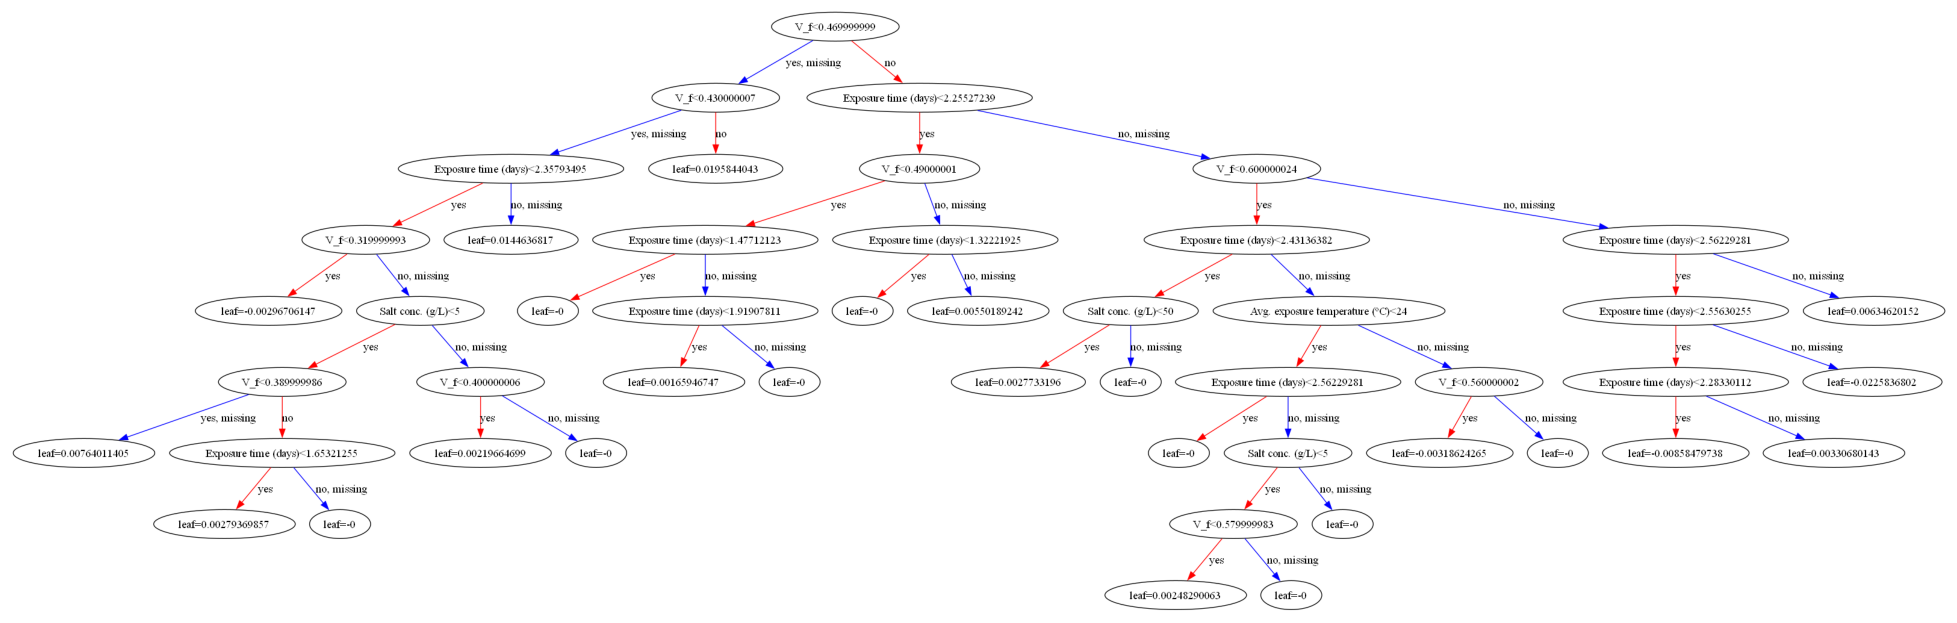

In [1537]:
predictor.plot_tree()

In [1538]:
from sklearn.model_selection import cross_val_score, KFold

df = load_dataset()
X = df.drop(columns=predictor.target)
y = df[predictor.target]

# Outer CV: Evaluate performance
for i in range(len(predictor.trained_models)):
    outer_scores = cross_val_score(
        predictor.trained_models[i]['model'], X, y, 
        cv=KFold(5, shuffle=True), 
        scoring='r2'
    )
    print(f"Unbiased R²: {np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")

Unbiased R²: 0.603 ± 0.096
Unbiased R²: 0.640 ± 0.048
Unbiased R²: 0.664 ± 0.076
Unbiased R²: 0.654 ± 0.081


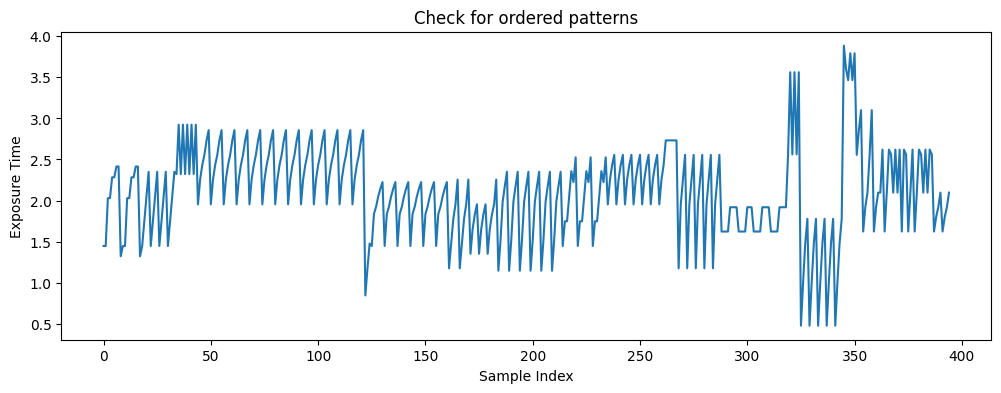

In [1539]:
plt.figure(figsize=(12, 4))
plt.plot(predictor.dataset['dataset']['Exposure time (days)'].values, label='Original Order')
plt.xlabel('Sample Index')
plt.ylabel('Exposure Time')
plt.title('Check for ordered patterns')
plt.show()

In [1540]:
# Fim do processamento
now = datetime.now()

print(now.strftime("%d/%m/%Y %H:%M:%S"))
print("\nProcessing time: %s seconds\n" % (round((time.time() - start_time), 2)))

11/04/2025 18:22:11

Processing time: 1559.96 seconds

